# Laboratorio 2

##### Javier Valle 20159
##### Mario de León 19026

## Haciendo análisis exploratorio.

In [1]:
# Imports necesarios.
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
import numpy as np
import re
from statsmodels.tsa.arima.model import ARIMA
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from arch.unitroot import PhillipsPerron
from pmdarima import auto_arima
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM, Dense

### Inciso 4:.Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como conjunto de prueba

In [2]:
# Cargar los datos históricos de precios (supongamos que está en un archivo CSV llamado 'consumo.csv')
data = pd.read_csv('consumo.csv')

# Convertir la columna 'fecha' a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha']).dt.date

In [3]:
def count_zeros_per_column(dataframe):
    zero_counts = dataframe.apply(lambda column: (column == 0).sum())
    return zero_counts

# Suponiendo que 'data' es tu DataFrame con los datos de 2020 al 2022
zero_counts = count_zeros_per_column(data)

# Imprimir la cantidad de ceros por columna
print(zero_counts)

Fecha                         0
Aceites lubricantes         228
Asfalto                       0
Bunker                        0
Ceras                       260
Combustible turbo jet        60
Diesel bajo azufre          216
Diesel ultra bajo azufre    216
Gas licuado de petróleo       0
Gasolina de aviación          1
Gasolina regular              0
Gasolina superior             0
Grasas lubricantes          228
Kerosina                      0
Mezclas oleosas             241
Naftas                      228
PetCoke                      49
Petróleo crudo               24
Solventes                   228
Butano                      234
Diesel alto azufre           65
Orimulsión                  253
Total                         0
dtype: int64


In [4]:
# Definir la lista de columnas a eliminar
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Diesel bajo azufre', 'Diesel ultra bajo azufre',
                   'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión', 'Kerosina']

# Eliminar las columnas con más de 200 datos faltantes
data.drop(columns=columns_to_drop, inplace=True)

# Filtrar solo la columna "Gasolina regular"
#data = data[['Fecha', 'Gasolina regular']]

# Llenar las columnas restantes con la media
columns_to_fill = data.columns[data.isnull().sum() > 0]
for col in columns_to_fill:
    col_mean = data[col].mean()
    data[col].fillna(col_mean, inplace=True)
    
# Llenar las columnas con ceros
columns_with_zeros = data.columns[data.eq(0).sum() > 0]
for col in columns_with_zeros:
    data[col].replace(0, data[col].mean(), inplace=True)

In [5]:
# Comprueba si quedan valores nulos en el DataFrame
print(data.isnull().sum())

# Verifica si quedan ceros en las columnas
print(data.eq(0).sum())

Fecha                      0
Asfalto                    0
Bunker                     0
Combustible turbo jet      0
Gas licuado de petróleo    0
Gasolina de aviación       0
Gasolina regular           0
Gasolina superior          0
PetCoke                    0
Petróleo crudo             0
Diesel alto azufre         0
Total                      0
dtype: int64
Fecha                      0
Asfalto                    0
Bunker                     0
Combustible turbo jet      0
Gas licuado de petróleo    0
Gasolina de aviación       0
Gasolina regular           0
Gasolina superior          0
PetCoke                    0
Petróleo crudo             0
Diesel alto azufre         0
Total                      0
dtype: int64


In [6]:
print(data)

          Fecha   Asfalto     Bunker  Combustible turbo jet  \
0    2000-01-01  48446.00  296766.99           35953.793274   
1    2000-02-01  50597.00  328116.44           35953.793274   
2    2000-03-01  27593.00  368589.63           35953.793274   
3    2000-04-01  53794.00  396300.47           35953.793274   
4    2000-05-01  60137.00  449368.92           35953.793274   
..          ...       ...        ...                    ...   
276  2023-01-01  77035.87  105294.71           73581.220000   
277  2023-02-01  74416.24  116577.42           66761.160000   
278  2023-03-01  69630.40  194492.83           83431.510000   
279  2023-04-01  74654.67  157844.83           80733.640000   
280  2023-05-01  76296.87  221002.66           73860.950000   

     Gas licuado de petróleo  Gasolina de aviación  Gasolina regular  \
0              194410.476190               1426.00         202645.20   
1              174710.552381               1458.00         205530.96   
2              189234.06666

In [7]:
# Dividir los datos en conjunto de entrenamiento (2020-2022) y conjunto de prueba (2023)
train_data = data[(data['Fecha'] >= pd.to_datetime('2020-01-01').date()) & (data['Fecha'] <= pd.to_datetime('2022-12-31').date())]
test_data = data[data['Fecha'] >= pd.to_datetime('2023-01-01').date()]

In [8]:
train_data

,Fecha,Asfalto,Bunker,Combustible turbo jet,Gas licuado de petróleo,Gasolina de aviación,Gasolina regular,Gasolina superior,PetCoke,Petróleo crudo,Diesel alto azufre,Total
240,2020-01-01,12977.57,132814.31,67346.00,421644.72,1137.95,640011.73,622323.79,307317.12,64486.00,592592.719087,3500222.47
241,2020-02-01,23258.89,145923.81,58608.78,426533.15,958.33,652028.00,633100.05,248778.51,104545.19,592592.719087,3569175.82
242,2020-03-01,19587.38,104824.84,37280.42,420637.14,946.43,573586.73,509752.95,306511.61,106949.57,592592.719087,3223968.68
243,2020-04-01,17494.20,51247.20,13870.41,345933.61,452.38,458420.85,391773.23,310990.98,53000.00,592592.719087,2537123.53
244,2020-05-01,35550.36,139347.72,17776.74,362987.37,380.95,478771.83,407482.52,366963.69,81524.00,592592.719087,2745842.36
245,2020-06-01,33842.05,114881.57,17381.30,402541.02,462.88,516933.60,388952.81,327627.60,70605.00,592592.719087,2688356.61
246,2020-07-01,43939.07,119704.27,19154.50,423328.22,571.45,567052.50,462380.81,281593.37,86576.00,592592.719087,2908363.29
247,2020-08-01,33601.74,129081.54,19506.82,483695.90,1017.10,647375.58,574379.33,274835.24,94364.00,592592.719087,3182976.13
248,2020-09-01,26005.63,123261.01,20238.47,439581.36,948.80,661665.58,610445.10,158485.71,95762.00,592592.719087,3139895.21
249,2020-10-01,37876.73,117108.19,29115.90,459312.45,1142.86,680362.07,648582.82,254131.92,128310.00,592592.719087,3472743.19


In [9]:
test_data

,Fecha,Asfalto,Bunker,Combustible turbo jet,Gas licuado de petróleo,Gasolina de aviación,Gasolina regular,Gasolina superior,PetCoke,Petróleo crudo,Diesel alto azufre,Total
276,2023-01-01,77035.87,105294.71,73581.22,574148.00,1224.04,804524.73,599501.29,427535.42,112435.87,592592.719087,4112993.69
277,2023-02-01,74416.24,116577.42,66761.16,497273.19,1134.43,737345.64,544144.00,311098.09,100237.67,592592.719087,3728618.58
278,2023-03-01,69630.40,194492.83,83431.51,588892.16,1514.78,875010.34,656941.64,311475.22,112090.14,592592.719087,4412648.89
279,2023-04-01,74654.67,157844.83,80733.64,513919.89,1390.03,798128.36,585642.20,322290.11,96434.73,592592.719087,3924688.62
280,2023-05-01,76296.87,221002.66,73860.95,565814.79,1790.83,866826.79,646221.20,508981.62,114448.93,592592.719087,4473315.73


In [10]:
# Contar valores negativos en el conjunto de datos de 2020 a 2022
negative_count_2020_2022 = (train_data.select_dtypes(include=['number']) < 0).sum().sum()

# Contar valores negativos en el conjunto de datos de 2023
negative_count_2023 = (test_data.select_dtypes(include=['number']) < 0).sum().sum()

print("Valores negativos en 2020-2022:", negative_count_2020_2022)
print("Valores negativos en 2023:", negative_count_2023)


Valores negativos en 2020-2022: 0
Valores negativos en 2023: 0


In [11]:
# Escalar los datos
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.drop(['Fecha'], axis=1))
test_data_scaled = scaler.transform(test_data.drop(['Fecha'], axis=1))

In [12]:
train_data_scaled

array([[0.        , 0.70436094, 0.66611124, 0.35915471, 0.66437909,
        0.44569771, 0.61551093, 0.28864283, 0.13522945, 0.        ,
        0.55929771],
       [0.17320324, 0.81756613, 0.55727727, 0.38234421, 0.50814567,
        0.47519051, 0.64393308, 0.19427523, 0.60686294, 0.        ,
        0.5993408 ],
       [0.11135151, 0.46266193, 0.29160353, 0.354375  , 0.49779506,
        0.2826638 , 0.31860776, 0.2873443 , 0.6351707 , 0.        ,
        0.39886963],
       [0.07608896, 0.        , 0.        , 0.        , 0.06807052,
        0.        , 0.0074388 , 0.2945653 , 0.        , 0.        ,
        0.        ],
       [0.38027027, 0.76077925, 0.04865866, 0.0808988 , 0.00594073,
        0.04994956, 0.04887171, 0.38479652, 0.3358249 , 0.        ,
        0.12120869],
       [0.3514914 , 0.54950537, 0.04373291, 0.2685315 , 0.07720342,
        0.14361403, 0.        , 0.32138448, 0.20727098, 0.        ,
        0.08782516],
       [0.52158984, 0.59115109, 0.06582053, 0.36714082, 0.

In [13]:
test_data_scaled

array([[1.0791518 , 0.46671943, 0.74377939, 1.08259242, 0.73926015,
        0.84947937, 0.55531707, 0.48244162, 0.69976319, 0.        ,
        0.9151506 ],
       [1.03502047, 0.56414963, 0.65882626, 0.7179174 , 0.6613174 ,
        0.68459462, 0.40931342, 0.29473797, 0.55614871, 0.        ,
        0.69193354],
       [0.95439629, 1.23697685, 0.86647815, 1.15253505, 0.99214571,
        1.02247966, 0.70681476, 0.29534592, 0.69569277, 0.        ,
        1.08916852],
       [1.03903715, 0.92050836, 0.83287251, 0.79688521, 0.8836382 ,
        0.83378008, 0.51876402, 0.31278014, 0.51137512, 0.        ,
        0.80579674],
       [1.06670231, 1.46589864, 0.7472638 , 1.04306174, 1.23225391,
        1.0023939 , 0.67853983, 0.61373757, 0.72346378, 0.        ,
        1.1243994 ]])

In [14]:
# Definir el número de pasos de tiempo y características
sequence_length = 1
num_features = train_data_scaled.shape[1]  # El número de columnas en train_data_scaled

In [15]:
# Crear secuencias de entrenamiento y etiquetas
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [16]:
# Crear secuencias de entrenamiento y etiquetas
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

In [17]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_test: (4, 1, 11)
Shape of y_test: (4, 11)


In [18]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (35, 1, 11)
Shape of y_train: (35, 11)


In [19]:
# Imprime algunos ejemplos de los datos originales antes del preprocesamiento
print("Ejemplos de datos originales:")
print(data.loc[:10, :])  # Imprime los primeros 10 ejemplos

# Imprime algunos ejemplos de los datos de prueba después del preprocesamiento
print("Ejemplos de datos de prueba después del preprocesamiento:")
print("X_test:")
print(X_test[:2])  # Imprime los primeros 2 ejemplos de X_test
print("y_test:")
print(y_test[:2])  # Imprime los primeros 2 ejemplos de y_test

# Verifica que los valores escalados estén en el rango esperado
print("Valores escalados:")
print("X_test:")
print(np.min(X_test), np.max(X_test))
print("y_test:")
print(np.min(y_test), np.max(y_test))

Ejemplos de datos originales:
         Fecha  Asfalto     Bunker  Combustible turbo jet  \
0   2000-01-01  48446.0  296766.99           35953.793274   
1   2000-02-01  50597.0  328116.44           35953.793274   
2   2000-03-01  27593.0  368589.63           35953.793274   
3   2000-04-01  53794.0  396300.47           35953.793274   
4   2000-05-01  60137.0  449368.92           35953.793274   
5   2000-06-01  40623.0  404033.69           35953.793274   
6   2000-07-01  36670.0  291436.20           35953.793274   
7   2000-08-01  25033.0  373811.63           35953.793274   
8   2000-09-01  16906.0  322718.89           35953.793274   
9   2000-10-01  22070.0  260955.42           35953.793274   
10  2000-11-01  25659.0  310274.26           35953.793274   

    Gas licuado de petróleo  Gasolina de aviación  Gasolina regular  \
0             194410.476190                1426.0         202645.20   
1             174710.552381                1458.0         205530.96   
2             189234.066

In [20]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_features))  # Salida con el mismo número de características
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), run_eagerly=True)

In [21]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
2/2 [==============================] - 0s 79ms/step - loss: 0.3110 - val_loss: 0.6569
Epoch 2/200
2/2 [==============================] - 0s 51ms/step - loss: 0.3064 - val_loss: 0.6504
Epoch 3/200
2/2 [==============================] - 0s 50ms/step - loss: 0.3022 - val_loss: 0.6438
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 0.2978 - val_loss: 0.6372
Epoch 5/200
2/2 [==============================] - 0s 51ms/step - loss: 0.2934 - val_loss: 0.6303
Epoch 6/200
2/2 [==============================] - 0s 52ms/step - loss: 0.2886 - val_loss: 0.6229
Epoch 7/200
2/2 [==============================] - 0s 50ms/step - loss: 0.2836 - val_loss: 0.6148
Epoch 8/200
2/2 [==============================] - 0s 51ms/step - loss: 0.2783 - val_loss: 0.6062
Epoch 9/200
2/2 [==============================] - 0s 51ms/step - loss: 0.2727 - val_loss: 0.5969
Epoch 10/200
2/2 [==============================] - 0s 51ms/step - loss: 0.2666 - val_loss: 0.5866
Epoch 11/200
2/2 [=

Epoch 84/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0295 - val_loss: 0.0933
Epoch 85/200
2/2 [==============================] - 0s 52ms/step - loss: 0.0295 - val_loss: 0.0925
Epoch 86/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0296 - val_loss: 0.0914
Epoch 87/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0297 - val_loss: 0.0903
Epoch 88/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0296 - val_loss: 0.0894
Epoch 89/200
2/2 [==============================] - 0s 53ms/step - loss: 0.0295 - val_loss: 0.0886
Epoch 90/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0294 - val_loss: 0.0879
Epoch 91/200
2/2 [==============================] - 0s 53ms/step - loss: 0.0293 - val_loss: 0.0877
Epoch 92/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0293 - val_loss: 0.0878
Epoch 93/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0293 - val_loss: 0.0873
Epoch 94/2

2/2 [==============================] - 0s 51ms/step - loss: 0.0273 - val_loss: 0.0927
Epoch 167/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0272 - val_loss: 0.0932
Epoch 168/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0272 - val_loss: 0.0942
Epoch 169/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0275 - val_loss: 0.0943
Epoch 170/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0274 - val_loss: 0.0926
Epoch 171/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0273 - val_loss: 0.0906
Epoch 172/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0271 - val_loss: 0.0892
Epoch 173/200
2/2 [==============================] - 0s 50ms/step - loss: 0.0271 - val_loss: 0.0885
Epoch 174/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0270 - val_loss: 0.0884
Epoch 175/200
2/2 [==============================] - 0s 51ms/step - loss: 0.0269 - val_loss: 0.0884
Epoch 176/200


In [22]:
# Realizar predicciones y desescalar
predictions = model.predict(X_test)
predictions_descaled = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 23ms/step


In [23]:
# Compara las predicciones desescaladas con los valores reales desescalados
print("Predicciones desescaladas:")
print(predictions_descaled)  # Imprime las primeras 2 predicciones desescaladas
print("Valores reales desescalados:")
print(scaler.inverse_transform(y_test))  # Imprime los primeros 2 valores reales desescalados

Predicciones desescaladas:
[[3.7229965e+04 1.3269886e+05 7.7758789e+04 5.5705538e+05 1.3733900e+03
  8.4418406e+05 6.1050994e+05 3.6728712e+05 1.2190171e+05 5.9259275e+05
  4.1065428e+06]
 [3.5660738e+04 1.2980871e+05 6.4880996e+04 5.1983716e+05 1.2258068e+03
  7.7038519e+05 6.0370888e+05 3.4038725e+05 1.1439595e+05 5.9259275e+05
  3.8414745e+06]
 [3.7886184e+04 1.3845980e+05 7.9390641e+04 5.6239419e+05 1.4059200e+03
  8.5121769e+05 6.2603456e+05 3.7019284e+05 1.2496956e+05 5.9259275e+05
  4.1749755e+06]
 [3.6514316e+04 1.3300212e+05 7.3018133e+04 5.4190862e+05 1.3237059e+03
  8.1438494e+05 6.1153238e+05 3.5305384e+05 1.1957566e+05 5.9259275e+05
  4.0093872e+06]]
Valores reales desescalados:
[[7.44162400e+04 1.16577420e+05 6.67611600e+04 4.97273190e+05
  1.13443000e+03 7.37345640e+05 5.44144000e+05 3.11098090e+05
  1.00237670e+05 5.92592719e+05 3.72861858e+06]
 [6.96304000e+04 1.94492830e+05 8.34315100e+04 5.88892160e+05
  1.51478000e+03 8.75010340e+05 6.56941640e+05 3.11475220e+05
  1

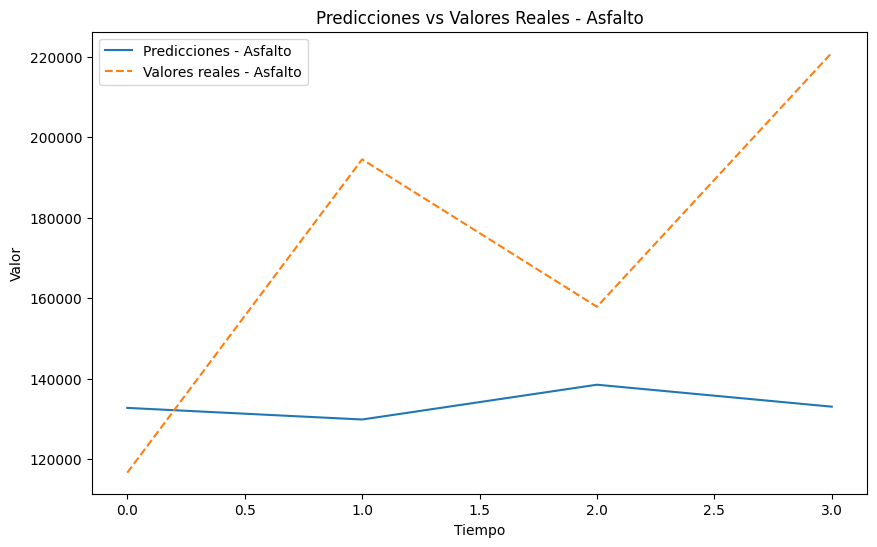

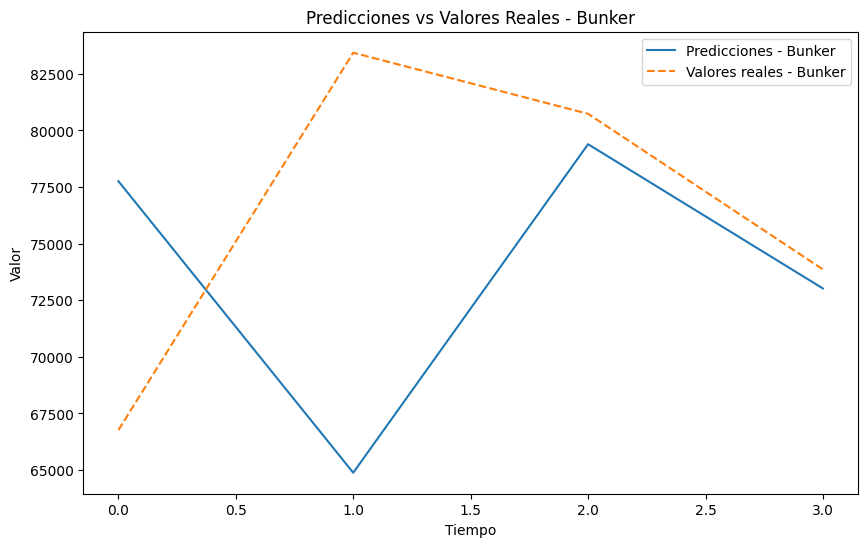

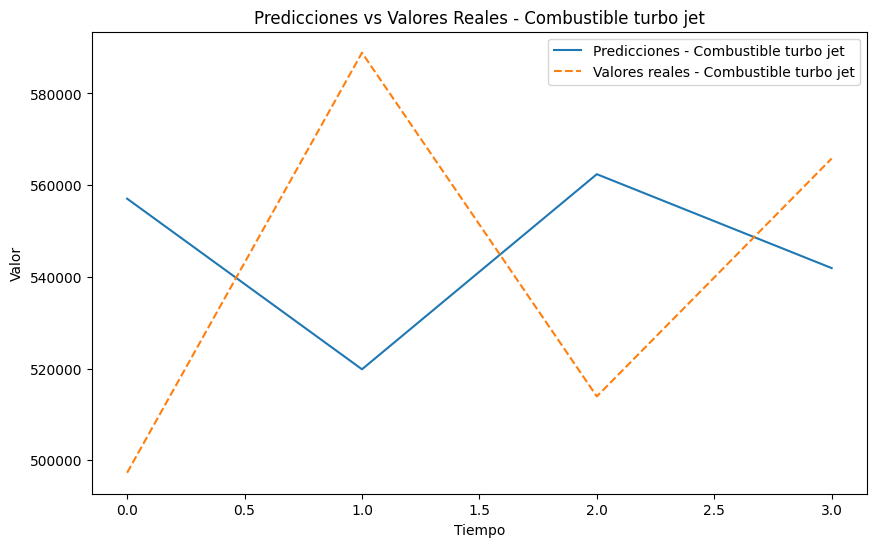

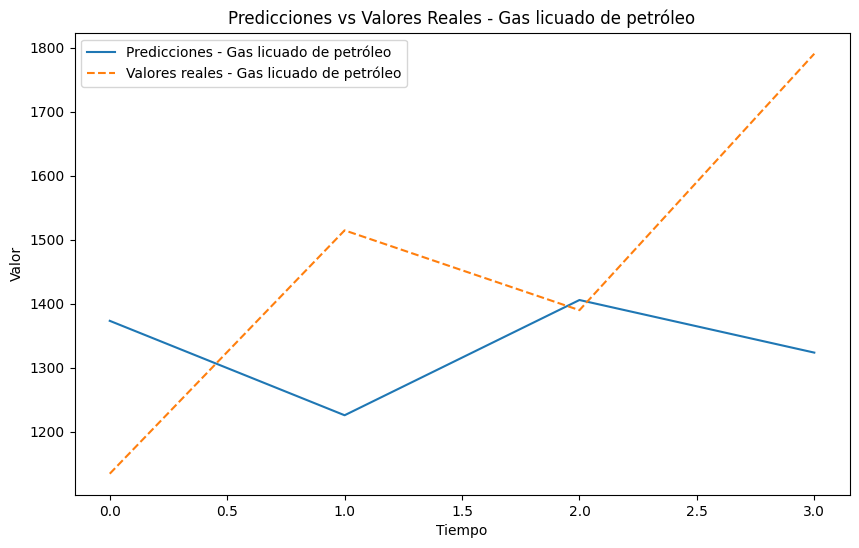

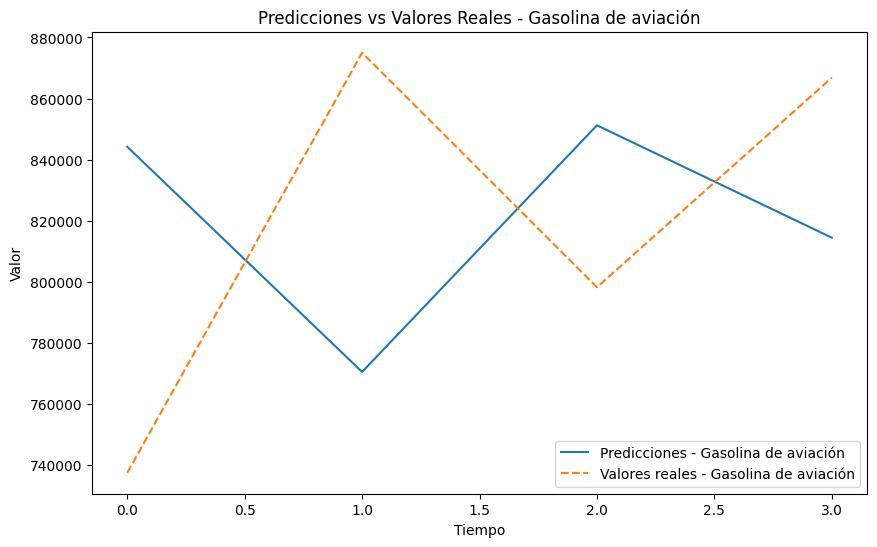

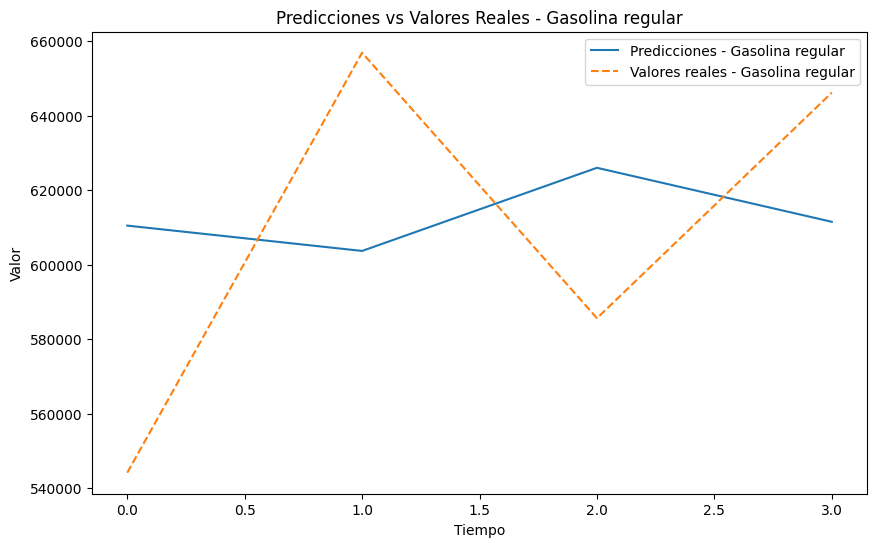

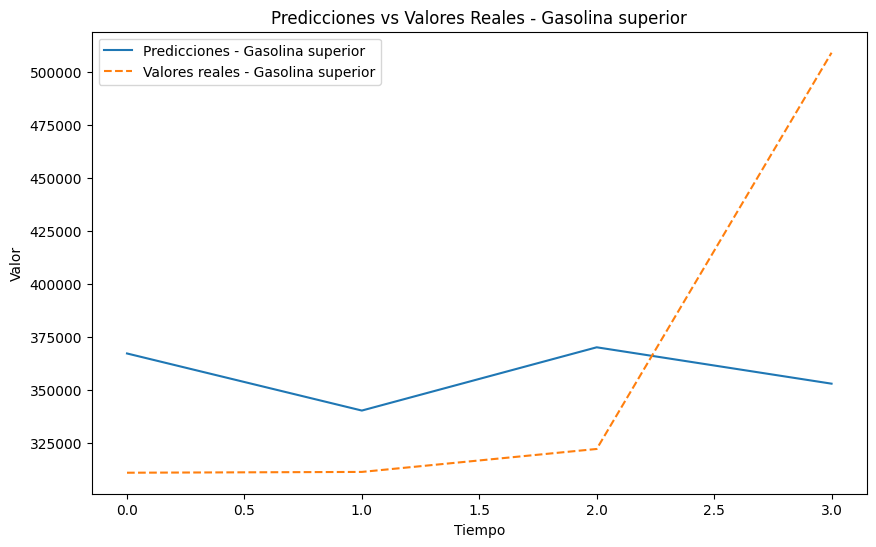

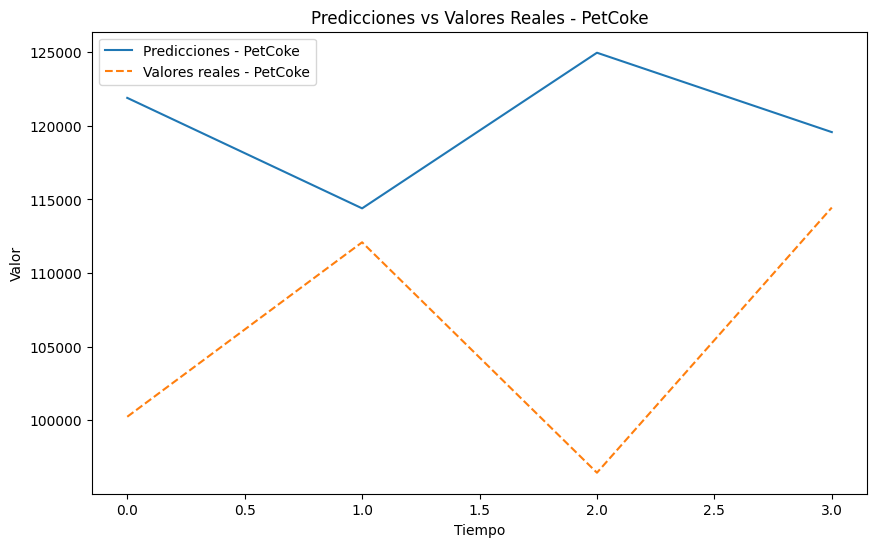

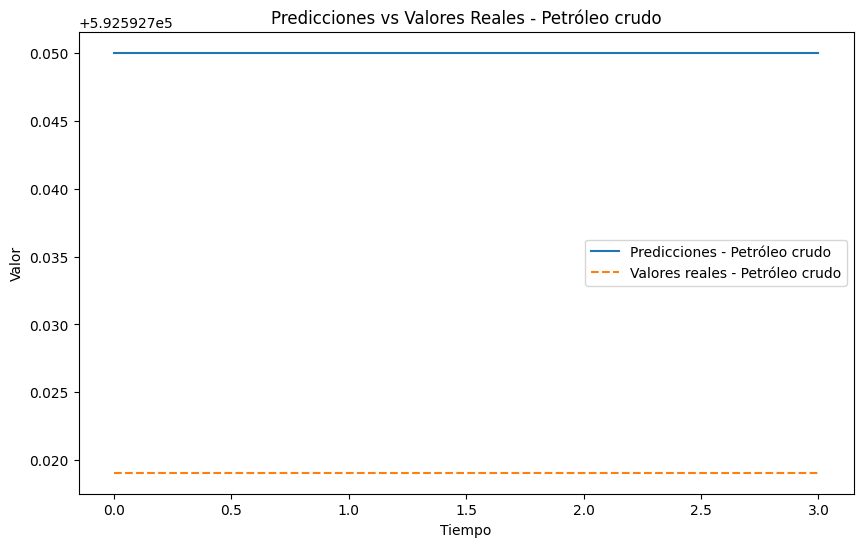

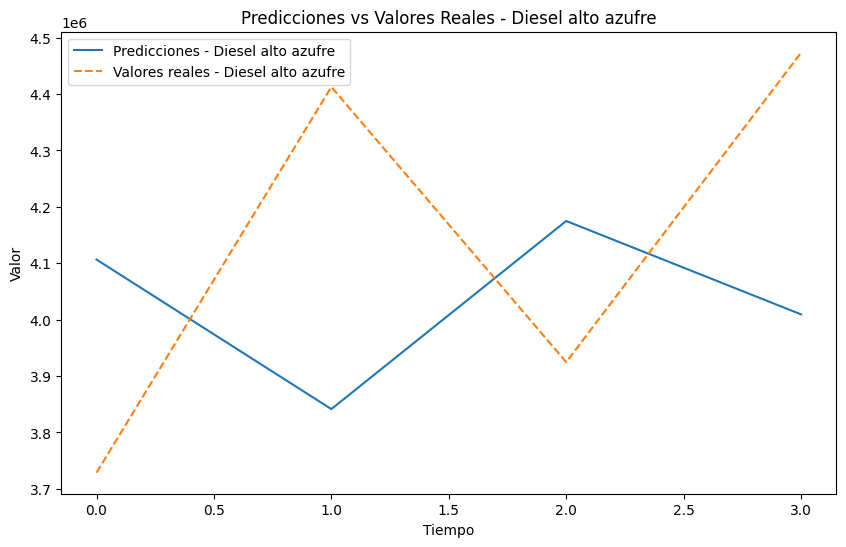

In [24]:
import matplotlib.pyplot as plt

# Crear un array con los índices de tiempo para el eje x
time_indices = range(len(predictions_descaled))

# Nombre de las columnas de los tipos de gasolina
columnas_gasolina = ['Asfalto', 'Bunker', 'Combustible turbo jet', 'Gas licuado de petróleo',
                     'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
                     'PetCoke', 'Petróleo crudo', 'Diesel alto azufre']

columnas_gasolina_test = ['Gasolina regular']


# Graficar las predicciones y los valores reales para cada tipo de gasolina en gráficas separadas [:, idx]
for columna in columnas_gasolina:
    idx = data.columns.get_loc(columna)
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_indices, predictions_descaled[:, idx], label='Predicciones - ' + columna)
    plt.plot(time_indices, scaler.inverse_transform(y_test)[:, idx], label='Valores reales - ' + columna, linestyle='dashed')
    
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    plt.title('Predicciones vs Valores Reales - ' + columna)
    plt.legend()
    plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Crear un diccionario para almacenar las métricas por tipo de gasolina
metrics_by_gasolina = {}

# Recorrer cada tipo de gasolina
for gasolina_column in columnas_gasolina:
    # Obtener el índice de la columna actual
    gasolina_idx = data.columns.get_loc(gasolina_column)
    
    # Obtener las predicciones y valores reales desescalados para la gasolina actual
    predictions_gasolina = predictions_descaled[:, gasolina_idx]
    y_test_gasolina = scaler.inverse_transform(y_test)[:, gasolina_idx]
    
    # Calcular el error cuadrático medio (MSE) y el coeficiente de determinación (R2)
    mse_gasolina = mean_squared_error(y_test_gasolina, predictions_gasolina)
    r2_gasolina = r2_score(y_test_gasolina, predictions_gasolina)
    
    # Almacenar las métricas en el diccionario
    metrics_by_gasolina[gasolina_column] = {'MSE': mse_gasolina, 'R2': r2_gasolina}

# Imprimir las métricas de evaluación por tipo de gasolina
for gasolina_column, metrics in metrics_by_gasolina.items():
    print(f"Tipo de gasolina: {gasolina_column}")
    print(f"Error cuadrático medio (MSE): {metrics['MSE']:.2f}")
    print(f"Coeficiente de determinación (R2): {metrics['R2']:.2f}")
    print("=" * 40)

Tipo de gasolina: Asfalto
Error cuadrático medio (MSE): 3140952433.99
Coeficiente de determinación (R2): -1.03
Tipo de gasolina: Bunker
Error cuadrático medio (MSE): 116895849.83
Coeficiente de determinación (R2): -1.79
Tipo de gasolina: Combustible turbo jet
Error cuadrático medio (MSE): 2815941357.35
Coeficiente de determinación (R2): -1.03
Tipo de gasolina: Gas licuado de petróleo
Error cuadrático medio (MSE): 89766.20
Coeficiente de determinación (R2): -0.61
Tipo de gasolina: Gasolina de aviación
Error cuadrático medio (MSE): 6982373911.49
Coeficiente de determinación (R2): -1.23
Tipo de gasolina: Gasolina regular
Error cuadrático medio (MSE): 2518255614.50
Coeficiente de determinación (R2): -0.19
Tipo de gasolina: Gasolina superior
Error cuadrático medio (MSE): 7650314109.99
Coeficiente de determinación (R2): -0.08
Tipo de gasolina: PetCoke
Error cuadrático medio (MSE): 328791857.94
Coeficiente de determinación (R2): -4.64
Tipo de gasolina: Petróleo crudo
Error cuadrático medio (M

Se está obteniendo un MSE alto y un valor negativo para el coeficiente de determinación (R^2), mostrando que las predicciones no están ajustando bien los datos reales. Un MSE alto indica que las predicciones están lejos de los valores reales en términos de magnitud, mientras que un valor negativo para el R^2 muestra que el modelo está realizando peor que simplemente predecir la media de los datos reales. Algunas posibles causas son:
Complejidad del modelo: Un MSE alto y un R2 negativo pueden ser muestra que el modelo de predicción usado no es capaz de capturar bien la variabilidad y los patrones en los datos de entrada.
Características no lineales: Si las relaciones entre las variables predictoras y las variables de respuesta (precios de gasolina) son no lineales, un modelo lineal como ARIMA o LSTM podría no ser capaz de modelarlas de manera efectiva.
Datos ruidosos: Si los datos de precios de gasolina están influenciados por ruido o fluctuaciones aleatorias, el modelo puede tener dificultades para identificar patrones significativos y hacer predicciones precisas.
Sobreajuste: Si el modelo se ha sobreajustado a los datos de entrenamiento puede resultar en predicciones inexactas en el conjunto de prueba.

### Inciso 5. Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual

Epoch 1/200
1/1 [==============================] - 1s 846ms/step - loss: 0.3721
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3689
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3658
Epoch 4/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3628
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3599
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3570
Epoch 7/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3542
Epoch 8/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3515
Epoch 9/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3488
Epoch 10/200
1/1 [==============================] - 0s 3ms/step - loss: 0.3461
Epoch 11/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3434
Epoch 12/200
1/1 [==============================] - 0s 2ms/step - loss: 0.3408
Epoch 13/200
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 0.1553
Epoch 105/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1536
Epoch 106/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1518
Epoch 107/200
1/1 [==============================] - 0s 2ms/step - loss: 0.1500
Epoch 108/200
1/1 [==============================] - 0s 2ms/step - loss: 0.1483
Epoch 109/200
1/1 [==============================] - 0s 4ms/step - loss: 0.1465
Epoch 110/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1446
Epoch 111/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1428
Epoch 112/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1410
Epoch 113/200
1/1 [==============================] - 0s 2ms/step - loss: 0.1391
Epoch 114/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1373
Epoch 115/200
1/1 [==============================] - 0s 3ms/step - loss: 0.1354
Epoch 116/200
1/1 [==============================] - 0

C:\Users\Gamer\AppData\Local\Temp\ipykernel_9564\1405938243.py:77: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(predictions_df['Fecha'], predictions_df[gas_column], linestyle='solid', marker=None)


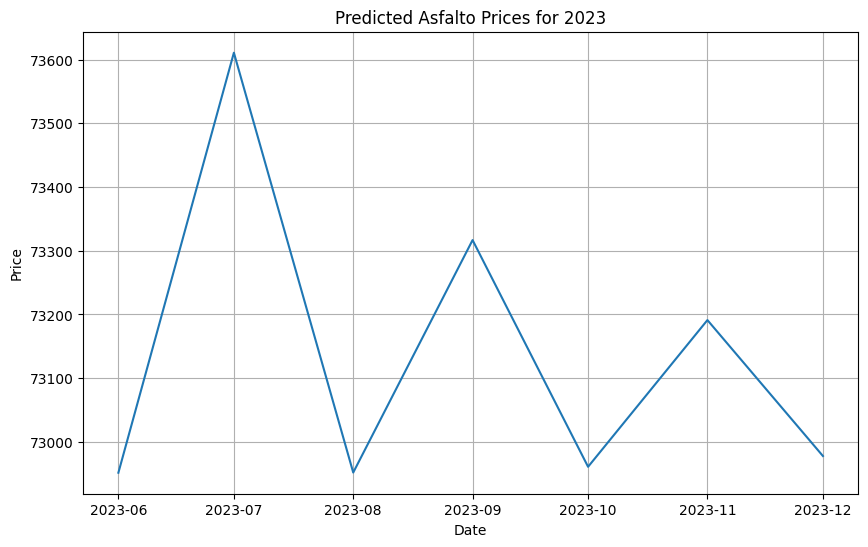

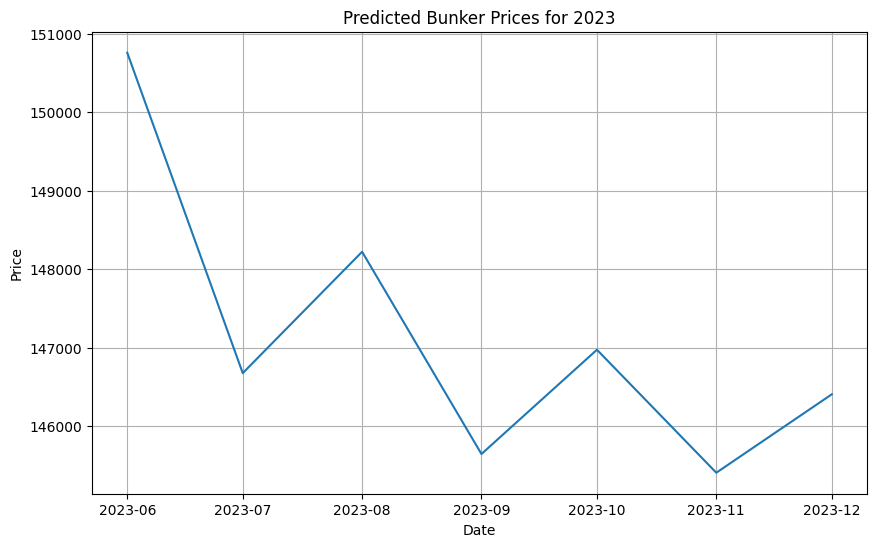

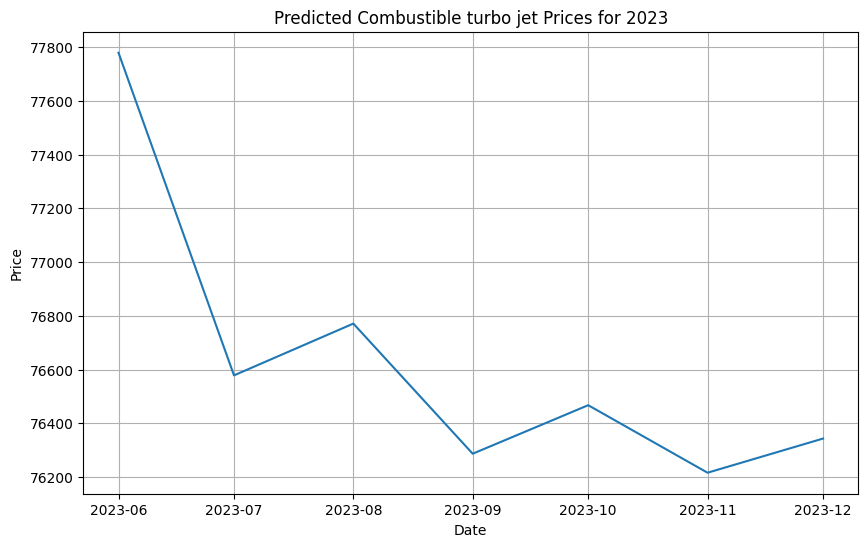

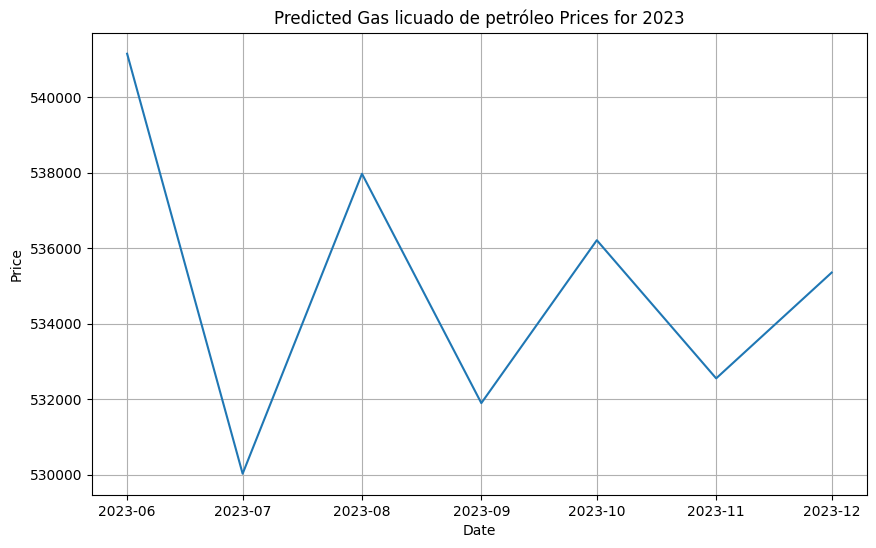

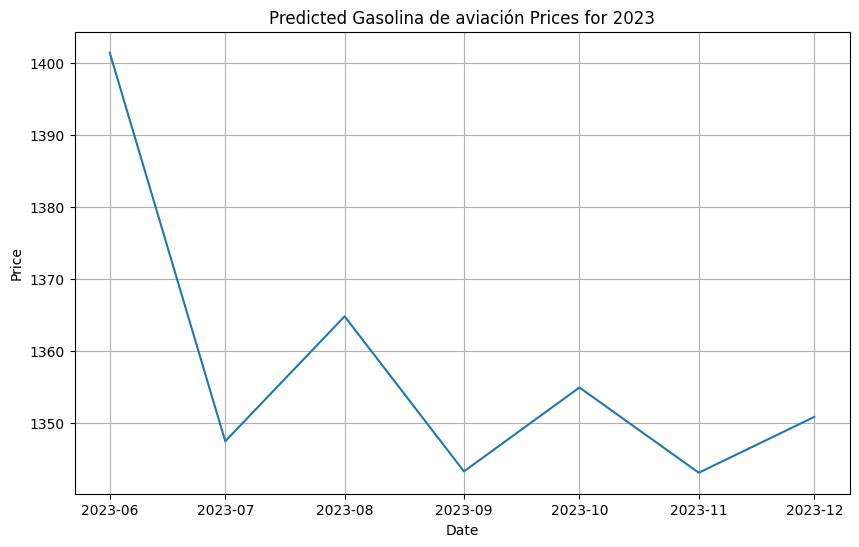

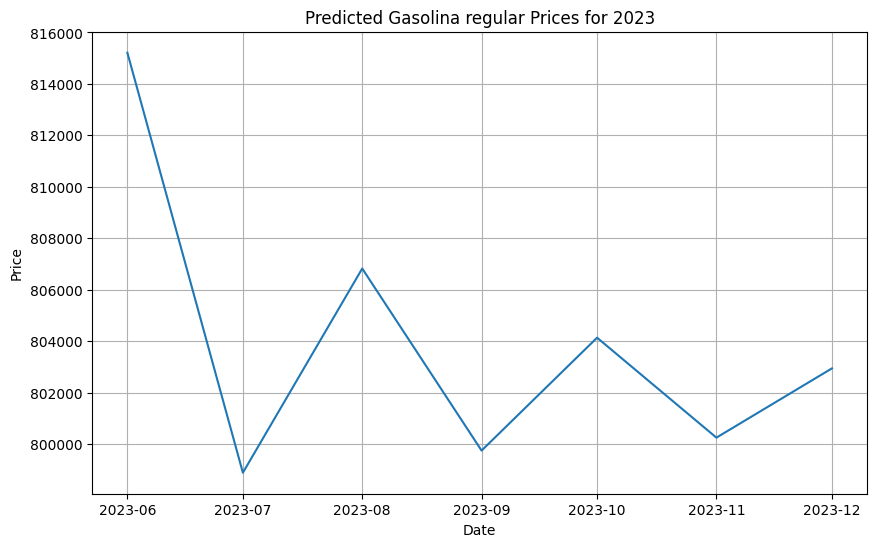

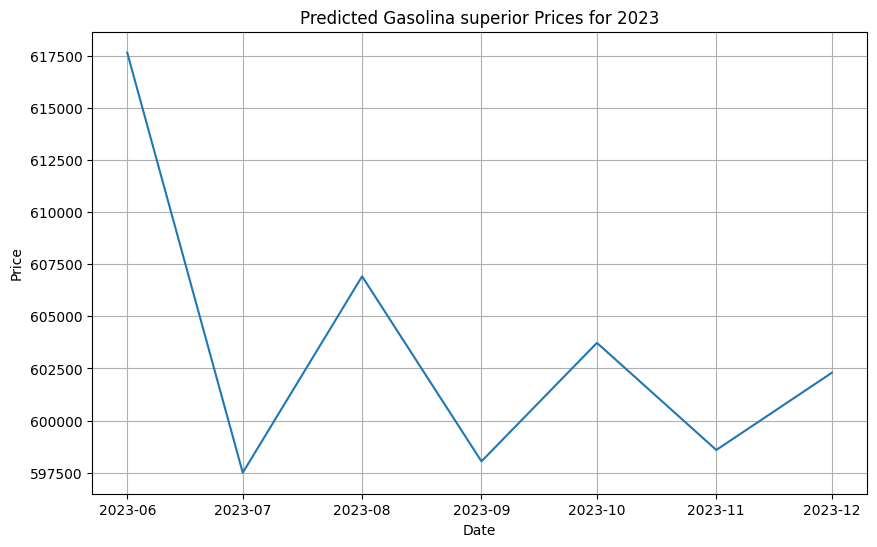

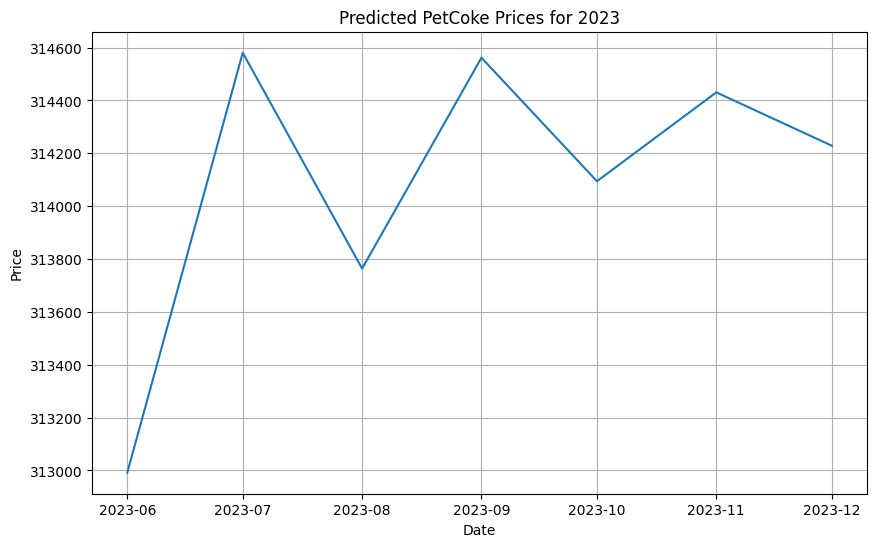

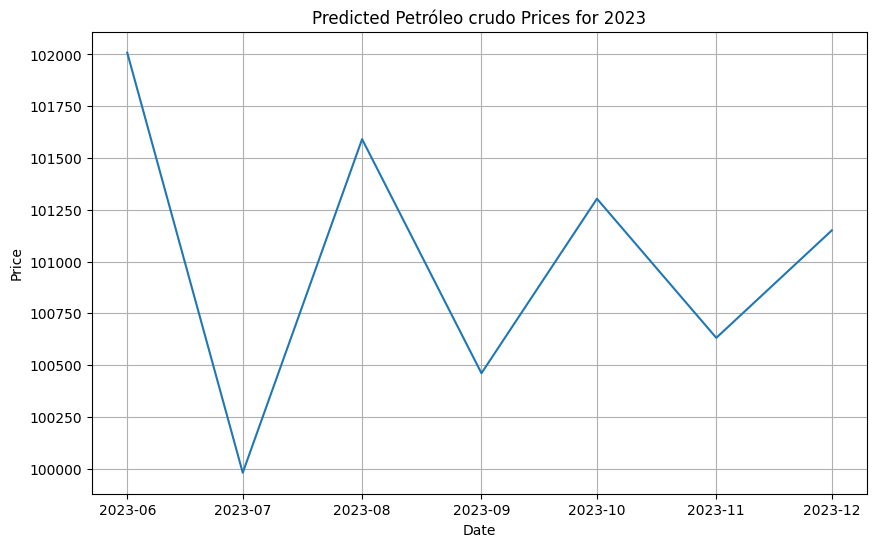

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('consumo.csv')

# Drop columns_to_drop from data_2023
columns_to_drop = ['Aceites lubricantes', 'Ceras', 'Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre',
                   'Grasas lubricantes', 'Mezclas oleosas', 'Naftas', 'Solventes', 'Butano', 'Orimulsión', 'Kerosina']
data.drop(columns=columns_to_drop, inplace=True)

data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

# Filter data for January to May
data_2023 = data['2023-01-01':'2023-05-01']

# Split data into train and test sets
train_data = data_2023.iloc[:-1]
test_data = data_2023.iloc[-1:]

# Normalize data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Create sequences for training
sequence_length = 1
X_train = []
y_train = []
for i in range(len(train_data_scaled) - sequence_length):
    X_train.append(train_data_scaled[i:i+sequence_length])
    y_train.append(train_data_scaled[i+sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Build and train the model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(data.columns))))
model.add(Dense(len(data.columns)))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200)

# Make predictions for the entire year
num_months = 7
X_test = [train_data_scaled[-sequence_length:]]
predictions_scaled = []
for _ in range(num_months):
    prediction_scaled = model.predict(np.array([X_test[-1]]))
    predictions_scaled.append(prediction_scaled)
    X_test.append(np.vstack((X_test[-1][1:], prediction_scaled)))

# Reshape predictions_scaled to 2D array
predictions_scaled = np.array(predictions_scaled).reshape(-1, len(data.columns))

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions_scaled)

# Create DataFrame with predicted values
num_months = 7  # Number of months to predict
predicted_dates = pd.date_range(start='2023-06-01', periods=num_months, freq='MS')
predictions_df = pd.DataFrame(data=predictions, columns=data_2023.columns)
predictions_df['Fecha'] = predicted_dates

# Plot predicted gas prices for each type of gas
gas_columns = ['Asfalto', 'Bunker', 'Combustible turbo jet', 'Gas licuado de petróleo',
               'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
               'PetCoke', 'Petróleo crudo']

for gas_column in gas_columns:
    plt.figure(figsize=(10, 6))
    plt.plot_date(predictions_df['Fecha'], predictions_df[gas_column], linestyle='solid', marker=None)
    plt.title(f'Predicted {gas_column} Prices for 2023')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

Para las predicciones del resto del año 2023:
Asfalto:
Se observa que los datos de 01-01 al 05-01 tienen picos bastante extremos entre datos. De enero a marzo el precio disminuyó considerablemente, y de marzo a abril incrementó de nuevo. La predicción tambien incluye estos picos extremos, y muestra que julio tendrá un precio alto, mientras va descendiendo con picos por el resto del año.

Bunker, Turbo Jet, Gas licuado, Gas de aviación, regular y superior presentan comportamientos similares, y aunque se ven picos, no son tan extremos. Por ejemplo, la gasolina regular oscila con una diferencia de aproximadamente 15,000. No hay descensos extremos, sólo graduales.
Otro ejemplo, la Gasolina superior, la cual tiene los siguientes valores reales: 599501.29 544144.00 656941.64 585642.20 646221.20. En la gráfica podemos ver que baja del ultimo precio de 646221.20 hasta el rango de 585,000. Esto es aceptable en el rango de precios al ver el comportamiendo de esta gasolina de enero a mayo.
 
En general, las gasolinas presentan un comportamiento normal que oscila entre los valores aceptables al compararlos con los datos reales de enero a mayo del 2023.


### Inciso 6. Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones?¿se recuperaron los valores habituales en el regreso a la “nueva normalidad”?

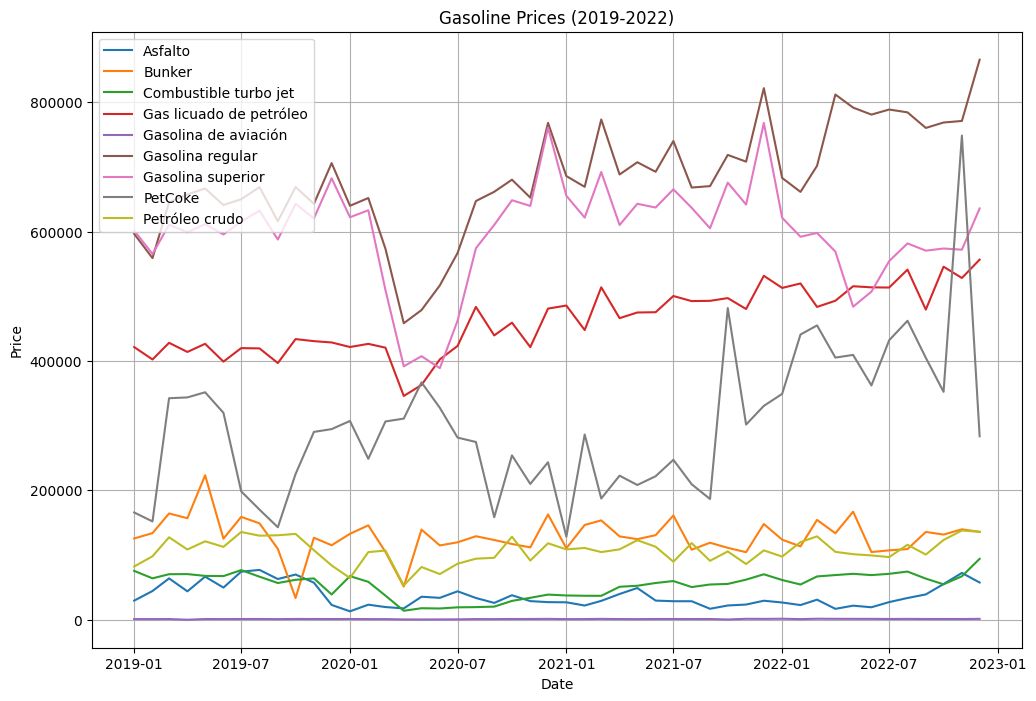

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el conjunto de datos completo
data = pd.read_csv('consumo.csv')

# Filtrar las columnas relevantes
columns_to_keep = ['Fecha', 'Asfalto', 'Bunker', 'Combustible turbo jet', 'Gas licuado de petróleo',
                   'Gasolina de aviación', 'Gasolina regular', 'Gasolina superior',
                   'PetCoke', 'Petróleo crudo', 'Diesel alto azufre']
data = data[columns_to_keep]

# Convertir la columna de fechas a tipo datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Filtrar los datos para el período 2019-2022
data = data[(data['Fecha'] >= '2019-01-01') & (data['Fecha'] <= '2022-12-31')]

# Graficar las series de precios de la gasolina
plt.figure(figsize=(12, 8))
plt.plot(data['Fecha'], data[gas_columns])
plt.title('Gasoline Prices (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(gas_columns, loc='upper left')
plt.grid(True)
plt.show()

Podemos ver que entre el 2020-01 y 2021-01 hay un pico extremo hacia abajo en las gasolinas regulares, superior, gas licuado, bunker y turbo jet. Es muy probable que este comportamiento tan extremo de descenso por el poco uso de medios de transporte haya afectado las predicciones del 2023. 
No cabe duda que la pandemia del Covid-19 tuvo un impacto enorme en la gasolina, y se debe tomar en cuenta (y manejar correctamente) este gran impacto en caso que se quiera predecir variables para años siguientes.